In [848]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.spatial.distance import pdist, squareform

class TripletEmbeddingCriterion(nn.Module):
    def __init__(self, margin=0.5, gamma=2):
        super(TripletEmbeddingCriterion, self).__init__()
        self.margin = margin
        self.gamma = gamma

    def forward(self, anchor, positive, negative):
        N = anchor.size(0)
        
        delta_pos = anchor - positive
        delta_neg = anchor - negative

        norm_delta_pos = torch.norm(delta_pos, p=2, dim=1)
        norm_delta_neg = torch.norm(delta_neg, p=2, dim=1)

        norm_delta_pos = norm_delta_pos * norm_delta_pos * self.gamma
        norm_delta_neg = norm_delta_neg * norm_delta_neg

        delta_pos_neg = norm_delta_pos - norm_delta_neg + self.margin

        loss = F.relu(delta_pos_neg)
        return loss.mean()

    def backward(self, anchor, positive, negative):
        N = anchor.size(0)
        
        delta_pos = anchor - positive
        delta_neg = anchor - negative

        norm_delta_pos = torch.norm(delta_pos, p=2, dim=1)
        norm_delta_neg = torch.norm(delta_neg, p=2, dim=1)

        norm_delta_pos = norm_delta_pos * norm_delta_pos * self.gamma
        norm_delta_neg = norm_delta_neg * norm_delta_neg

        delta_pos_neg = norm_delta_pos - norm_delta_neg + self.margin

        mask = (delta_pos_neg > 0).float().view(-1, 1)

        grad_anchor = mask * (delta_neg - delta_pos * self.gamma) * (2 / N)
        grad_positive = mask * (delta_pos * self.gamma) * (-2 / N)
        grad_negative = mask * delta_neg * (2 / N)

        return grad_anchor, grad_positive, grad_negative




In [849]:
import random
import numpy as np
import torch

def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #torch.use_deterministic_algorithms = True


torch_fix_seed()

In [875]:
import torch
import torch.nn.functional as F

class AggClustering:
    def __init__(self):
        self.K_c = 5

    def init(self, indices):
        # nsamples = indices.size(0)
        # visited = torch.full((nsamples, 1), -1, dtype=torch.int32)
        # count = 0
        # for i in range(nsamples):
        #     cur_idx = i
        #     pos = []
        #     while visited[cur_idx, 0] == -1:
        #         pos.append(cur_idx)
        #         neighbor = 0
        #         for k in range(indices.size(0)):
        #             neighbor = indices[cur_idx, k].item()
        #             if cur_idx != neighbor:
        #                 break
        #         visited[cur_idx, 0] = -2
        #         cur_idx = neighbor
        #         if len(pos) > 50:
        #             break
        #     if visited[cur_idx, 0] < 0:
        #         visited[cur_idx, 0] = count
        #         count += 1
        #     for p in pos:
        #         visited[p, 0] = visited[cur_idx, 0]
        # label_indice = [[] for _ in range(count)]
        # for i in range(nsamples):
        #     label_indice[visited[i, 0]].append(i)
        # return label_indice

        # # Initialize labels for input data given KNN indices
        # nsamples = indices.size(0)
        # k = indices.size(1)
        # visited = torch.full((nsamples, 1), -1, dtype=torch.int)
        # count = 0
        
        # for i in range(nsamples):
        #     cur_idx = i
        #     pos = []
        #     while visited[cur_idx][0] == -1:
        #         pos.append(cur_idx)
        #         neighbor = 0
        #         for k_idx in range(indices[cur_idx].size(0)):
        #             neighbor = indices[cur_idx][k_idx].item()
        #             if cur_idx != neighbor:
        #                 break
        #         visited[cur_idx][0] = -2
        #         cur_idx = neighbor
        #         if len(pos) > 50:
        #             break
            
        #     if visited[cur_idx][0] < 0:
        #         visited[cur_idx][0] = count
        #         count += 1
            
        #     for j in pos:
        #         visited[j][0] = visited[cur_idx][0]
        
        # label_indices = [[] for _ in range(count)]
        
        # for i in range(nsamples):
        #     label_indices[visited[i][0]].append(i)
        
        # for i in range(count):
        #     if len(label_indices[i]) == 0:
        #         print("error")
        # print(label_indices)

        # サンプル間の距離行列を計算
        nsamples = indices
        distances = squareform(pdist(nsamples, 'euclidean'))

        # 距離の上三角行列をフラット化し、ソートして最も距離が短い3ペアを見つける
        triu_indices = np.triu_indices_from(distances, k=1)
        sorted_distances_indices = np.argsort(distances[triu_indices])
        shortest_3_pairs_indices = sorted_distances_indices[:3]

        # 最も距離が短い3ペアのインデックスを取得
        shortest_3_pairs = list(zip(triu_indices[0][shortest_3_pairs_indices], triu_indices[1][shortest_3_pairs_indices]))

        # 全サンプルのインデックスのセットを作成
        all_indices = set(range(len(nsamples)))

        # グループ化する
        label_indices = []
        grouped_indices = set()
        
        for pair in shortest_3_pairs:
            if pair[0] not in grouped_indices and pair[1] not in grouped_indices:
                group = list(pair)
                label_indices.append(group)
                grouped_indices.update(pair)
            else:
                for group in label_indices:
                    if pair[0] in group or pair[1] in group:
                        group.extend([idx for idx in pair if idx not in group])
                        grouped_indices.update(pair)
                        break

        # 残りの単一要素をリストに追加
        remaining_indices = all_indices - grouped_indices
        for index in remaining_indices:
            label_indices.append([index])

        print(label_indices)
        return label_indices

    # def merge_two_clusters(self, W, A_s_t, A_us_t, Y_t, idx_c_a, idx_c_b):
    #     A_us_t[:, idx_c_a] += A_us_t[:, idx_c_b]
    #     nsamples_c_a = len(Y_t[idx_c_a])
    #     nsamples_c_b = len(Y_t[idx_c_b])
    #     ratio = nsamples_c_a / (nsamples_c_a + nsamples_c_b)
    #     A_us_t[idx_c_a, :] *= ratio
    #     A_us_t[idx_c_b, :] *= (1 - ratio)
    #     A_us_t[idx_c_a, :] += A_us_t[idx_c_b, :]
    #     A_us_t[idx_c_a, idx_c_a] = 0
    #     A_us_t[:, idx_c_b] = 0
    #     A_us_t[idx_c_b, :] = 0
    #     Y_t[idx_c_a].extend(Y_t[idx_c_b])
    #     Y_t[idx_c_b] = []
    #     for i in range(len(Y_t)):
    #         if len(Y_t[i]) == 0 or i == idx_c_a:
    #             A_s_t[i, idx_c_a] = 0
    #             A_s_t[idx_c_a, i] = 0
    #         elif i < idx_c_a:
    #             A_s_t[i, idx_c_a] = A_us_t[idx_c_a, i] / len(Y_t[idx_c_a])**2 + A_us_t[i, idx_c_a] / len(Y_t[i])**2
    #         elif i > idx_c_a:
    #             A_s_t[idx_c_a, i] = A_us_t[idx_c_a, i] / len(Y_t[idx_c_a])**2 + A_us_t[i, idx_c_a] / len(Y_t[i])**2
    #     return A_s_t, A_us_t, Y_t


    def merge_two_clusters(W, A_s_t, A_us_t, Y_t, idx_c_a, idx_c_b):
        nclusters = len(Y_t)

        idx_c_a_tensor = torch.tensor([idx_c_a], dtype=torch.long)
        idx_c_b_tensor = torch.tensor([idx_c_b], dtype=torch.long)

        A_us_t.index_add_(1, idx_c_a_tensor, A_us_t.index_select(1, idx_c_b_tensor))

        nsamples_c_a = len(Y_t[idx_c_a])
        nsamples_c_b = len(Y_t[idx_c_b])
        ratio = nsamples_c_a / (nsamples_c_a + nsamples_c_b)

        A_us_t[idx_c_a, :] *= ratio
        A_us_t[idx_c_b, :] *= (1 - ratio)
        A_us_t.index_add_(0, idx_c_a_tensor, A_us_t.index_select(0, idx_c_b_tensor))

        A_us_t[idx_c_a, idx_c_a] = 0
        A_us_t[:, idx_c_b] = 0
        A_us_t[idx_c_b, :] = 0

        Y_t[idx_c_a].extend(Y_t[idx_c_b])
        Y_t[idx_c_b] = []

        for i in range(nclusters):
            if len(Y_t[i]) == 0 or i == idx_c_a:
                A_s_t[i, idx_c_a] = 0
                A_s_t[idx_c_a, i] = 0
            elif i < idx_c_a:
                A_s_t[i, idx_c_a] = A_us_t[idx_c_a, i] / (len(Y_t[idx_c_a]) ** 2) + A_us_t[i, idx_c_a] / (len(Y_t[i]) ** 2)
            elif i > idx_c_a:
                A_s_t[idx_c_a, i] = A_us_t[idx_c_a, i] / (len(Y_t[idx_c_a]) ** 2) + A_us_t[i, idx_c_a] / (len(Y_t[i]) ** 2)

        return A_s_t, A_us_t, Y_t

    # def search_clusters(self, A_s_t):
    #     A_sorted, idx_sort = torch.sort(A_s_t, dim=1, descending=True)
    #     aff = torch.zeros(1, A_sorted.size(1))
    #     for i in range(A_sorted.size(1)):
    #         aff[0, i] = A_sorted[0, i]
    #         if A_sorted.size(1) > 100:
    #             for k in range(1, self.K_c):
    #                 aff[0, i] += (A_sorted[0, i] - A_sorted[k, i]) / (self.K_c - 1)
    #     v_c, idx_c = torch.max(aff, 1)
    #     idx_c_b = idx_c.item()
    #     idx_c_a = idx_sort[0, idx_c_b].item()
    #     if idx_c_a == idx_c_b:
    #         raise ValueError("Error: idx_c_a == idx_c_b")
    #     if idx_c_a > idx_c_b:
    #         idx_c_a, idx_c_b = idx_c_b, idx_c_a
    #     return idx_c_a, idx_c_b

    def search_clusters(self, A_s_t):
        # print("cluster numbers:", nclusters)
        nclusters = A_s_t.size(0)  # クラスタの数を取得
        A_sorted, idx_sort = torch.sort(A_s_t, dim=0, descending=True)
        # print("A_s_t: ", A_s_t.size())
        # print("nclusters: ", nclusters)
        # print("A_sorted: ", A_sorted)
        # print("idx_sort: ", idx_sort)
        aff = torch.zeros(1, A_sorted.size(1), dtype=torch.float32)

        for i in range(A_sorted.size(1)):
            aff[0, i] = A_sorted[0, i]
            if A_sorted.size(1) > 100:
                for k in range(1, self.K_c):
                    aff[0, i] += (A_sorted[0, i] - A_sorted[k, i]) / (self.K_c - 1)

        v_c, idx_c = torch.max(aff, dim=1)  # each row
        # print("idx_c: ", idx_c)
        # find corresponding cluster labels for two clusters
        idx_c_b = idx_c[0].item()         # col
        idx_c_a = idx_sort[0, idx_c_b].item()        # row

        # インデックスの検証と調整
        if idx_c_a >= nclusters or idx_c_b >= nclusters:
            raise ValueError(f"Error: idx_c_a ({idx_c_a}) or idx_c_b ({idx_c_b}) is out of range (nclusters: {nclusters})")
        if idx_c_a == idx_c_b:
            print("error")
            raise ValueError("idx_c_a and idx_c_b are the same")
        elif idx_c_a > idx_c_b:
            idx_c_a, idx_c_b = idx_c_b, idx_c_a

        return idx_c_a, idx_c_b

    # def search_clusters(self,A_s_t):
    #     # Sort the tensor along the first dimension in descending order
    #     A_sorted, Idx_sort = torch.sort(A_s_t, dim=0, descending=True)
        
    #     # Initialize affinity tensor
    #     aff = torch.zeros(1, A_sorted.size(1))
        
    #     for i in range(A_sorted.size(1)):
    #         aff[0, i] = A_sorted[0, i]
    #         if A_sorted.size(1) > 100:
    #             for k in range(1, self.K_c ):  # Adjusting index for Python's 0-based indexing
    #                 aff[0, i] += (A_sorted[0, i] - A_sorted[k, i]) / (self.K_c - 1)
        
    #     # Find the maximum value in the affinity tensor along the second dimension
    #     v_c, idx_c = torch.max(aff, dim=1)
        
    #     # Find corresponding cluster labels for two clusters
    #     idx_c_b = idx_c.item()  # Converting tensor to integer
    #     idx_c_a = Idx_sort[0, idx_c_b].item()  # Converting tensor to integer
        
    #     if idx_c_a == idx_c_b:
    #         print("error")
    #         raise ValueError("Cluster indices are equal, which indicates an error.")
    #     elif idx_c_a > idx_c_b:
    #         idx_c_a, idx_c_b = idx_c_b, idx_c_a  # Swap values
        
    #     return idx_c_a, idx_c_b


    def run_step(self, W, A_s_t, A_us_t, Y_t):
        nclusters = len(Y_t)
        # print("Cluster Num: ", nclusters)
        # print("numc",A_s_t.size(0))
        idx_c_a, idx_c_b = self.search_clusters(A_s_t)
        A_us_t[:, idx_c_a] += A_us_t[:, idx_c_b]
        Y_t[idx_c_a].extend(Y_t[idx_c_b])
        Y_t[idx_c_b] = []
        for i in range(len(Y_t)):
            if len(Y_t[i]) > 0 and i != idx_c_a:
                W_i = W[Y_t[i], :]
                W_i_idx_c_a = W_i[:, Y_t[idx_c_a]]
                W_idx_c_a = W[Y_t[idx_c_a], :]
                W_idx_c_a_i = W_idx_c_a[:, Y_t[i]]
                A_us_t[idx_c_a, i] = torch.sum(torch.mm(W_idx_c_a_i, W_i_idx_c_a))
        A_us_t[idx_c_a, idx_c_a] = 0
        A_us_t[:, idx_c_b] = 0
        A_us_t[idx_c_b, :] = 0
        for i in range(nclusters):
            if len(Y_t[i]) == 0 or i == idx_c_a:
                A_s_t[i, idx_c_a] = 0
                A_s_t[idx_c_a, i] = 0
            elif i < idx_c_a:
                A_s_t[i, idx_c_a] = A_us_t[idx_c_a, i] / len(Y_t[idx_c_a])**2 + A_us_t[i, idx_c_a] / len(Y_t[i])**2
            elif i > idx_c_a:
                A_s_t[idx_c_a, i] = A_us_t[idx_c_a, i] / len(Y_t[idx_c_a])**2 + A_us_t[i, idx_c_a] / len(Y_t[i])**2
        A_s_t[:, idx_c_b] = 0
        A_s_t[idx_c_b, :] = 0
        return A_s_t, A_us_t, Y_t

    # def run_step_fast(self,W, A_s_t, A_us_t, Y_t):
    #     # timer = torch.Timer()
    #     # get the number of clusters
    #     nclusters = len(Y_t)
    #     print("Cluster Num: ", nclusters)
    #     print("numc",A_s_t.size(0))
    #     # print("Cluster Num: ", nclusters)
    #     # find maximal value in A_t
    #     idx_c_a, idx_c_b = self.search_clusters(A_s_t)
    #     # update affinity matrix A_t
    #     # update A_t(idx_c_a->i) = A_t(idx_c_a->i) + A_t(idx_c_b->i)
    #     A_us_t.index_add_(1, torch.LongTensor([idx_c_a]), A_us_t.index_select(1, torch.LongTensor([idx_c_b])))

    #     # update A_t(i->idx_c_a) = r_a * A_t(i->idx_c_a) + r_b * A_t(i->idx_c_b) (fast algorithm)
    #     # nsamples in cluster idx_c_a
    #     A_us_t.index_add_(0, torch.LongTensor([idx_c_a]), A_us_t.index_select(0, torch.LongTensor([idx_c_b])))
        
    #     # update cluster labels Y_t   
    #     print("y_t: ", Y_t)
    #     print("idx_c_a: ", idx_c_a)
    #     print("idx_c_b: ", idx_c_b)
    #     Y_t[idx_c_a].extend(Y_t[idx_c_b])
    #     Y_t[idx_c_b] = []
        
    #     # update A_s_t   
    #     for i in range(nclusters):
    #         if len(Y_t[i]) == 0 or i == idx_c_a:
    #             A_s_t[i, idx_c_a] = 0
    #             A_s_t[idx_c_a, i] = 0
    #         elif i < idx_c_a:
    #             A_s_t[i, idx_c_a] =  A_us_t[idx_c_a, i] / (len(Y_t[idx_c_a]) ** 2) + A_us_t[i, idx_c_a] / (len(Y_t[i]) ** 2)
    #         elif i > idx_c_a:
    #             A_s_t[idx_c_a, i] =  A_us_t[idx_c_a, i] / (len(Y_t[idx_c_a]) ** 2) + A_us_t[i, idx_c_a] / (len(Y_t[i]) ** 2)

    #     # print(A_us_t.size())
    #     # print(nclusters)
    #     if idx_c_b != nclusters:
    #         # print(idx_c_b)
    #         # print(A_us_t.index_select(0, torch.LongTensor([1])))
    #         A_us_t.index_copy_(0, torch.LongTensor([idx_c_b]), A_us_t.index_select(0, torch.LongTensor([nclusters-1])))
    #         A_us_t.index_copy_(1, torch.LongTensor([idx_c_b]), A_us_t.index_select(1, torch.LongTensor([nclusters-1])))
    #         A_us_t[idx_c_b, idx_c_b] = 0

    #         # print("Pre: ", A_s_t[:idx_c_b+1, idx_c_b])
    #         # print("Pre: ", A_s_t[idx_c_b, idx_c_b:nclusters])
    #         A_s_t[:idx_c_b+1, idx_c_b] = A_s_t[:idx_c_b+1, nclusters-1]      
    #         A_s_t[idx_c_b, idx_c_b:nclusters] = A_s_t[idx_c_b:nclusters, nclusters-1].t()
    #         A_s_t[idx_c_b, idx_c_b] = 0
    #         # print("Cur: ", A_s_t[:idx_c_b+1, idx_c_b])
    #         # print("Cur: ", A_s_t[idx_c_b, idx_c_b:nclusters])

    #         Y_t[idx_c_b].extend(Y_t[nclusters-1])

    #     A_us_t = A_us_t[:nclusters-1, :nclusters-1]
    #     A_s_t = A_s_t[:nclusters-1, :nclusters-1]
    #     del Y_t[nclusters-1]   
    #     # print(Y_t)
    #     # timer = torch.Timer()
    #     # print('Time-2 elapsed: ' .. timer:time().real .. ' seconds')
    #     # return updated A_s_t, A_us_t and Y_t
    #     return A_s_t, A_us_t, Y_t

    def run_step_fast(self, W, A_s_t, A_us_t, Y_t):
        nclusters = len(Y_t)
        idx_c_a, idx_c_b = self.search_clusters(A_s_t)

        A_us_t.index_add_(1, torch.LongTensor([idx_c_a]), A_us_t.index_select(1, torch.LongTensor([idx_c_b])))
        A_us_t.index_add_(0, torch.LongTensor([idx_c_a]), A_us_t.index_select(0, torch.LongTensor([idx_c_b])))

        # print("y_t: ", Y_t)
        # print("idx_c_a: ", idx_c_a)
        # print("idx_c_b: ", idx_c_b)
        Y_t[idx_c_a].extend(Y_t[idx_c_b])
        Y_t[idx_c_b] = []

        for i in range(nclusters):
            if len(Y_t[i]) == 0 or i == idx_c_a:
                A_s_t[i, idx_c_a] = 0
                A_s_t[idx_c_a, i] = 0
            elif i < idx_c_a:
                A_s_t[i, idx_c_a] = A_us_t[idx_c_a, i] / (len(Y_t[idx_c_a]) ** 2) + A_us_t[i, idx_c_a] / (len(Y_t[i]) ** 2)
            elif i > idx_c_a:
                A_s_t[idx_c_a, i] = A_us_t[idx_c_a, i] / (len(Y_t[idx_c_a]) ** 2) + A_us_t[i, idx_c_a] / (len(Y_t[i]) ** 2)

        if idx_c_b != nclusters - 1:
            A_us_t.index_copy_(0, torch.LongTensor([idx_c_b]), A_us_t.index_select(0, torch.LongTensor([nclusters-1])))
            A_us_t.index_copy_(1, torch.LongTensor([idx_c_b]), A_us_t.index_select(1, torch.LongTensor([nclusters-1])))
            A_us_t[idx_c_b, idx_c_b] = 0

            A_s_t[:idx_c_b+1, idx_c_b] = A_s_t[:idx_c_b+1, nclusters-1].clone()
            A_s_t[idx_c_b, idx_c_b:nclusters] = A_s_t[idx_c_b:nclusters, nclusters-1].clone().t()
            A_s_t[idx_c_b, idx_c_b] = 0

            Y_t[idx_c_b].extend(Y_t[nclusters-1])

        # Update the size of A_s_t and A_us_t to match the new number of clusters
        A_us_t = A_us_t[:nclusters-1, :nclusters-1]
        A_s_t = A_s_t[:nclusters-1, :nclusters-1]
        del Y_t[nclusters-1]

        return A_s_t, A_us_t, Y_t





    def run(self, W, A_unsym_0, A_sym_0, Y_0, T, K_c_in, use_fast):
        nclusters = len(Y_0)
        A_sym_0_sum = torch.sum(A_sym_0, dim=1)
        self.K_c = K_c_in
        t = 0
        while t < T:
            if use_fast:
                A_sym_0, A_unsym_0, Y_0 = self.run_step_fast(W, A_sym_0, A_unsym_0, Y_0)
            else:
                A_sym_0, A_unsym_0, Y_0 = self.run_step(W, A_sym_0, A_unsym_0, Y_0)
            t += 1
        Y_T = [cluster for cluster in Y_0 if len(cluster) > 0]
        return Y_T

In [876]:
import torch
from sklearn.neighbors import NearestNeighbors
import time

class Affinity:
    def compute(self, X, k):
        #print("Xtype", X.dtype)
        #print("k", k)
        if X.size(0) > 50000:
            ind = torch.arange(1, X.size(0) + 1).long().split(10000)
            dists = torch.zeros(X.size(0), k + 1, dtype=X.dtype)
            indices = torch.zeros(X.size(0), k + 1, dtype=torch.int)

            for v in ind:
                nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X.detach().numpy())
                dists_batch, indices_batch = nbrs.kneighbors(X[v - 1].detach().numpy())
                dists[v - 1] = torch.tensor(dists_batch)
                indices[v - 1] = torch.tensor(indices_batch)
        else:
            #print('now')
            nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(X.detach().numpy())
            dists, indices = nbrs.kneighbors(X.detach().numpy())
            dists = torch.tensor(dists)
            indices = torch.tensor(indices)

        sigma_square = torch.mean(dists[:, 1:k+1])
        print("sigma:", torch.sqrt(sigma_square))

        nsamples = X.size(0)
        W = torch.zeros(nsamples, nsamples)

        for i in range(nsamples):
            for j in range(1, k + 1):
                nn_ind = indices[i][j]
                W[i][nn_ind] = torch.exp(-dists[i][j] / sigma_square)
        
        return dists, indices, W

    def compute4cluster(self, X, W, Y_0, k, k_target, min_clusters):
        nclusters = len(Y_0)
        dim = X.size(1)
        X_clusters = torch.zeros(nclusters, dim)

        for i in range(nclusters):
            X_clusters[i] = torch.mean(X[torch.LongTensor(Y_0[i])], dim=0)

        nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(X_clusters.detach().numpy())
        dists, indices = nbrs.kneighbors(X_clusters.detach().numpy())
        dists = torch.tensor(dists)
        indices = torch.tensor(indices)

        NNs = torch.zeros(nclusters, nclusters)
        # print(indices.size())

        for i in range(nclusters):
            for j in range(1, indices.size(1)):
                nn_ind = indices[i][j]
                NNs[i][nn_ind] = 1

        max_number = max(len(y) for y in Y_0)
        Y_0_tensor = torch.zeros(nclusters, max_number)

        for i in range(nclusters):
            for j in range(len(Y_0[i])):
                Y_0_tensor[i][j] = Y_0[i][j]

        timer = time.time()
        A_unsym_0_c, A_sym_0_c = self.compute_CAff(W, NNs, Y_0_tensor)

        if k > 20 * k_target:
            A_unsym_0_c = A_unsym_0_c.double()
            A_sym_0_c = A_sym_0_c.double()

            A_unsym_0_c_sum_r = torch.sum(A_unsym_0_c, dim=1)
            A_unsym_0_c_sum_c = torch.sum(A_unsym_0_c, dim=0)

            for i in range(nclusters):
                if A_unsym_0_c_sum_r[i] == 0 and A_unsym_0_c_sum_c[i] == 0:
                    idx_a = i
                    idx_b = 0
                    for k in range(indices.size(1)):
                        if indices[i][k] != i:
                            idx_b = indices[i][k]
                            break


                    # クラスタ数が最小クラスタ数を下回らないようにチェック
                    if nclusters <= min_clusters:
                        print(f"クラスタ数が最小クラスタ数 {min_clusters} を下回るため、クラスタ結合を停止します。")
                        return A_unsym_0_c, A_sym_0_c, Y_0

                    if idx_b > 0:
                        if idx_a > idx_b:
                            #print("merge", idx_b, idx_a)
                            A_sym_0_c, A_unsym_0_c, Y_0 = self.merge_two_clusters(W, A_sym_0_c, A_unsym_0_c, Y_0, idx_b, idx_a)
                        else:
                            #print("merge", idx_a, idx_b)
                            A_sym_0_c, A_unsym_0_c, Y_0 = self.merge_two_clusters(W, A_sym_0_c, A_unsym_0_c, Y_0, idx_a, idx_b)

                        A_unsym_0_c_sum_r = torch.sum(A_unsym_0_c, dim=1)
                        A_unsym_0_c_sum_c = torch.sum(A_unsym_0_c, dim=0)

        print('Time elapsed for computing cluster affinity:', time.time() - timer, 'seconds')
        # print("Y_0: ", Y_0)
        # print("A_unsym_0_c: ", A_unsym_0_c.size())
        # print("A_sym_0_c: ", A_sym_0_c.size())
        return A_unsym_0_c, A_sym_0_c, Y_0

    # def compute_CAff(self, W, NNs, Y_0_tensor):
    #     # Placeholder function to simulate compute_CAff. Actual implementation required.
    #     A_unsym_0_c = torch.rand(W.size())
    #     A_sym_0_c = torch.rand(W.size())
    #     return A_unsym_0_c, A_sym_0_c

    def compute_CAff(self,W, NNs, Y):
        nclusters = NNs.size(0)
        
        A_us = torch.zeros_like(NNs)
        A_s = torch.zeros_like(NNs)

        for i in range(nclusters):
            for j in range(i, nclusters):
                if NNs[i, j] == 0 and NNs[j, i] == 0:
                    A_us[j, i] = 0
                    A_us[i, j] = 0
                    A_s[j, i] = 0
                    A_s[i, j] = 0
                    continue

                if i == j:
                    A_us[j, i] = 0
                    A_s[j, i] = 0
                    continue

                # get the size of Y[i] and Y[j]
                Y_i_size = (Y[i] != 0).sum().item()
                Y_j_size = (Y[j] != 0).sum().item()

                if Y_i_size == 0 or Y_j_size == 0:
                    continue
                # compute affinity from cluster i to cluster j
                A_c_i_j = 0
                for m in range(Y_i_size):
                    s_W_c_j_i = 0
                    s_W_c_i_j = 0
                    for n in range(Y_j_size):
                        s_W_c_j_i += W[Y[j, n].long() - 1, Y[i, m].long() - 1]
                        s_W_c_i_j += W[Y[i, m].long() - 1, Y[j, n].long() - 1]
                    A_c_i_j += s_W_c_j_i * s_W_c_i_j

                # compute affinity from cluster j to cluster i
                A_c_j_i = 0
                for m in range(Y_j_size):
                    s_W_c_j_i = 0
                    s_W_c_i_j = 0
                    for n in range(Y_i_size):
                        s_W_c_j_i += W[Y[j, m].long() - 1, Y[i, n].long() - 1]
                        s_W_c_i_j += W[Y[i, n].long() - 1, Y[j, m].long() - 1]
                    A_c_j_i += s_W_c_i_j * s_W_c_j_i

                A_us[j, i] = A_c_i_j
                A_us[i, j] = A_c_j_i
                # print('Y_i_size:', Y_i_size)
                # print('Y_j_size:', Y_j_size)
                A_s[i, j] = A_c_i_j / (Y_j_size ** 2) + A_c_j_i / (Y_i_size ** 2)
                A_s[j, i] = 0

        return A_us, A_s


    def merge_two_clusters(self, W, A_s_t, A_us_t, Y_t, idx_c_a, idx_c_b):
        nclusters = len(Y_t)

        nsamples_c_a = len(Y_t[idx_c_a])
        nsamples_c_b = len(Y_t[idx_c_b])
        if nsamples_c_a == 0 or nsamples_c_b == 0:
            print(f"Skipping merge as one of the clusters is empty: idx_c_a={idx_c_a}, nsamples_c_a={nsamples_c_a}, idx_c_b={idx_c_b}, nsamples_c_b={nsamples_c_b}")
            return A_s_t, A_us_t, Y_t

        A_us_t[:, idx_c_a] += A_us_t[:, idx_c_b]
        ratio = nsamples_c_a / (nsamples_c_a + nsamples_c_b)

        A_us_t[idx_c_a] *= ratio
        A_us_t[idx_c_b] *= 1 - ratio
        A_us_t[idx_c_a] += A_us_t[idx_c_b]
        A_us_t[idx_c_a, idx_c_a] = 0
        A_us_t[:, idx_c_b] = 0
        A_us_t[idx_c_b, :] = 0

        Y_t[idx_c_a].extend(Y_t[idx_c_b])
        Y_t[idx_c_b] = []

        for i in range(nclusters):
            if len(Y_t[i]) == 0 or i == idx_c_a:
                A_s_t[i, idx_c_a] = 0
                A_s_t[idx_c_a, i] = 0
            elif i < idx_c_a:
                A_s_t[i, idx_c_a] = A_us_t[idx_c_a, i] / (len(Y_t[idx_c_a]) ** 2) + A_us_t[i, idx_c_a] / (len(Y_t[i]) ** 2)
            elif i > idx_c_a:
                A_s_t[idx_c_a, i] = A_us_t[idx_c_a, i] / (len(Y_t[idx_c_a]) ** 2) + A_us_t[i, idx_c_a] / (len(Y_t[i]) ** 2)

        return A_s_t, A_us_t, Y_t

In [877]:
class Evaluate:
    def NMI(self, labels_gt, labels_pre):
        N = sum(len(l) for l in labels_gt)
        # Compute entropy for labels_gt
        pr_gt = torch.zeros(len(labels_gt), 1)
        for i, label in enumerate(labels_gt):
            pr_gt[i] = len(label) / N
        pr_gt_log = torch.log(pr_gt)
        H_gt = -torch.sum(pr_gt * pr_gt_log)

        # Compute entropy for labels_pre
        pr_pre = torch.zeros(len(labels_pre), 1)
        for i, label in enumerate(labels_pre):
            pr_pre[i] = len(label) / N
        pr_pre_log = torch.log(pr_pre)
        H_pre = -torch.sum(pr_pre * pr_pre_log)

        # Compute mutual information
        # Build M_gt
        M_gt = torch.zeros(N, len(labels_gt))
        for i, label in enumerate(labels_gt):
            for j in label:
                if j < N:  # Ensure the index is within bounds
                    M_gt[j, i] = 1  # Keep it zero-based

        # Build M_pre
        M_pre = torch.zeros(N, len(labels_pre))
        for i, label in enumerate(labels_pre):
            for j in label:
                if j < N:  # Ensure the index is within bounds
                    M_pre[j, i] = 1  # Keep it zero-based

        pr_gp = torch.mm(M_gt.t(), M_pre) / N
        pr_gp_log = torch.log(pr_gp + 1e-10)
        H_gp = -torch.sum(pr_gp * pr_gp_log)

        # Compute mutual information
        MI = H_gt + H_pre - H_gp
        NMI = MI / torch.sqrt(H_gt * H_pre)

        return NMI.item()

In [878]:
import torch
import torch.nn as nn
import torch.optim as optim
import h5py
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import random
import os
import argparse

In [879]:
# 直接スクリプト内で設定するオプション
class Options:
    dataset = 'custom'
    eta = 0.2
    epoch_rnn = 1
    batchSize = 1000
    learningRate = 0.01
    weightDecay = 5e-5
    momentum = 0.9
    gamma_lr = 0.0001
    power_lr = 0.75
    num_nets = 1
    epoch_pp = 20
    epoch_max = 1000
    K_s = 5
    K_c = 5
    gamma_tr = 1
    margin_tr = 0.2
    num_nsampling = 5
    use_fast = 1
    updateCNN = 1
    centralize_input = 0
    centralize_feature = 0
    normalize = 1

opt = Options()


In [880]:
import pandas as pd
from datautils import _get_time_features,load_forecast_csv
data, train_slice, valid_slice, test_slice, scaler, pred_lens, data1=load_forecast_csv("phone/phone_data_10",False)

data
(7352, 10)
Index([   0.0,    1.0,    2.0,    3.0,    4.0,    5.0,    6.0,    7.0,    8.0,
          9.0,
       ...
       7342.0, 7343.0, 7344.0, 7345.0, 7346.0, 7347.0, 7348.0, 7349.0, 7350.0,
       7351.0],
      dtype='float64', name='date', length=7352)
(7352, 10)
data
(7352, 10)
slice(None, 4411, None)
slice(4411, 5881, None)
slice(5881, None, None)
(1, 7352, 10)


/Users/katoutsubasa/ts2vec/datautils.py:140: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(f'datasets/{name}.csv', index_col='date', parse_dates=True)


In [881]:
# ファイルのパス
file_path = 'datasets/phone/y_train.txt'

# ファイルを読み込む
with open(file_path, 'r') as file:
    lines = file.readlines()

# データをリストに変換
data_y = []
for line in lines:
    # 行の空白を削除し、カンマで分割して浮動小数点数に変換
    numbers = [float(num) for num in line.strip().split(',')]
    data_y.append(numbers)

# リストをPyTorchのテンソルに変換
data=torch.tensor(data)
tensor_data_y = torch.tensor(data_y)[:1000]
tensor_data_y=tensor_data_y.reshape(1000)
y=tensor_data_y

In [882]:
# # ベクトルデータの定義
# input_size = 320  # 入力ベクトルの次元
# X = torch.randn(50, input_size)  # 50個の320次元ベクトル
# y = torch.randint(0, 5, (50,))  # 0から4までのランダムなラベル
#print(data)
#print(data.size())
print(y.size())
print("NaN in X:", torch.isnan(data).any())
print("NaN in y:", torch.isnan(y).any())

class CustomVectorDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# データセットとデータローダーの作成
dataset = CustomVectorDataset(data[:,:1000,], y)
data_loader = DataLoader(dataset, batch_size=opt.batchSize, shuffle=False)
print(data_loader)

torch.Size([1000])
NaN in X: tensor(False)
NaN in y: tensor(False)


In [883]:
# データのロード
def load_data(data_loader):
    data = []
    labels = []
    for vectors, lbls in data_loader:
        data.append(vectors)
        labels.append(lbls)
    data = torch.cat(data)
    labels = torch.cat(labels)
    return data, labels

labels_y=torch.tensor(y)
print(labels_y.size())
train_data, train_labels = load_data(data_loader)
print("train_data: ", train_data.size())
print("train_labels: ", train_labels.size())

torch.Size([1000])
train_data:  torch.Size([1, 1000, 10])
train_labels:  torch.Size([1])


/var/folders/m9/vc40_2nj7wgb3tgln7x3gdzc0000gn/T/ipykernel_7028/325030253.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_y=torch.tensor(y)


In [884]:
# if opt.centralize_input == 1:
#     train_data -= train_data.mean(dim=0, keepdim=True)

test_data = train_data.clone()
test_labels = labels_y.clone()
print(test_labels)

tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 6., 6., 6.,
        6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
        6., 6., 6., 6., 6., 6., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 6., 6., 6.,
        6., 6., 6., 6., 6., 6., 6., 6., 

In [885]:
# Initialize networks
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

affinity = Affinity()
evaluate = Evaluate()
agg_clustering = AggClustering()

In [886]:
def load_model(input_size):
    model = nn.Sequential(
        nn.Linear(input_size, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )
    return model

In [887]:
# Initialize CNN models and variables
print('==> configuring model')
num_networks = opt.num_nets
network_table = []
optimizer_table = []
criterion_triplet = TripletEmbeddingCriterion(opt.margin_tr, opt.gamma_tr)

==> configuring model


In [888]:
for _ in range(num_networks):
    model = load_model(320)
    model.apply(init_weights)
    network_table.append(model)
    optimizer = optim.SGD(model.parameters(), lr=opt.learningRate, weight_decay=opt.weightDecay, momentum=opt.momentum)
    optimizer_table.append(optimizer)

In [889]:
label_gt_table_table = []
label_pre_table_table = []
label_pre_tensor_table = []
target_nclusters_table = []
labels_log=[]

In [890]:
def cvt2TableLabels(labels):
    unique_labels = torch.unique(labels)
    label_table = {label.item(): [] for label in unique_labels}
    for idx, label in enumerate(labels):
        label_table[label.item()].append(idx)
    return list(label_table.values())

print(cvt2TableLabels(test_labels))
for _ in range(num_networks):
    label_gt_table_table.append(cvt2TableLabels(test_labels))
    label_pre_table_table.append([])
    label_pre_tensor_table.append([])
    target_nclusters_table.append(len(label_gt_table_table[-1]))
print(target_nclusters_table)


[[78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 

In [891]:
!pip install kneed

In [892]:
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from sklearn.cluster import KMeans
saiteki_number_list=[]

from collections import Counter

def most_common_elements(lst):
    if not lst:
        return None  # リストが空の場合は None を返す
    counter = Counter(lst)
    max_count = counter.most_common(1)[0][1]  # 最も多い出現回数を取得
    most_common_elements = [elem for elem, count in counter.items() if count == max_count]
    return most_common_elements[0]

def estimate_optimal_clusters(features):
    max_clusters = min(20, len(features))  # 最大クラスタ数をデータサイズに応じて制限
    distortions = []
    silhouette_scores = []
    
    for k in range(2, max_clusters):
        labels = KMeans(n_clusters=k,n_init=20).fit_predict(features.detach().numpy() )
        distortions.append(KMeans(n_clusters=k,n_init=20).fit(features.detach().numpy()).inertia_)
        silhouette_scores.append(silhouette_score(features.detach().numpy(), labels))
    
    kl = KneeLocator(range(2, max_clusters), distortions, curve="convex", direction="decreasing")
    optimal_clusters_elbow = kl.elbow
    optimal_clusters_silhouette = silhouette_scores.index(max(silhouette_scores)) + 2
    saiteki_number= max(optimal_clusters_elbow, optimal_clusters_silhouette)
    saiteki_number_list.append(saiteki_number)
    if (len(saiteki_number_list)>3):
        saiteki_number_list.pop(0)
    #saiteki_number_list.append(saiteki_number)
    print('saiteki_number_list',saiteki_number_list)
    print("saiteki_class:",most_common_elements(saiteki_number_list))
    return most_common_elements(saiteki_number_list)

epoch_reset_labels = [0] * num_networks

def getnClusters(label_pre):
    nClusters = 0
    for cluster in label_pre:
        if len(cluster) > 0:
            nClusters += 1
    return nClusters

def update_labels(features, label_pre, target_clusters, iter,estimate_optimal_clusters):
    # print("compute affinity, ", features.size())
    d, ind, W = affinity.compute(features, opt.K_s)  # sigma_l not used here
    # sigma = sigma_l
    if iter == 0:
        print("initialize clusters...")
        # print("ind", ind.size())
        label_pre = agg_clustering.init(ind)
        # print("nclusters: ", getnClusters(label_pre))
        return label_pre

    print("nclusters: ", getnClusters(label_pre))
    A_us, A_s, label_pre = affinity.compute4cluster(features, W, label_pre, getnClusters(label_pre), target_clusters,estimate_optimal_clusters)
    # print("nclusters affinity_compute: ", getnClusters(label_pre))
    n_clusters = getnClusters(label_pre)
    # print("A_s", A_s.size())
    # print("new_n_clusters", n_clusters)
    #12
    print("run agglomerative clustering...")

    # Convert n_clusters to tensor
    n_clusters_tensor = torch.tensor(n_clusters, dtype=torch.float32)
    unfold_iter = torch.ceil(n_clusters_tensor * opt.eta).item()
    unfold_valid_iter = n_clusters - target_clusters
    iterations = min(unfold_iter, unfold_valid_iter)

    if iterations <= 0:
        print("nclusters:1Time: ", getnClusters(label_pre))
        return label_pre

    label_pre = agg_clustering.run(W, A_us, A_s, label_pre, iterations, opt.K_c, opt.use_fast)
    return label_pre

def extract_features(model, data):
    model.eval()
    with torch.no_grad():
        features = []
        for batch in DataLoader(CustomVectorDataset(data, torch.zeros(len(data))), batch_size=opt.batchSize, shuffle=False):
            inputs, _ = batch
            inputs = inputs
            outputs = model(inputs)
            features.append(outputs.cpu())
    return torch.cat(features)

def cvt2TensorLabels(labels):
    tensor_labels = torch.zeros(sum(len(l) for l in labels), dtype=torch.long)
    for cluster_id, cluster in enumerate(labels):
        tensor_labels[cluster] = cluster_id + 1
    return tensor_labels.unsqueeze(1)

def merge_labels(network_table, epoch_reset_labels, train_data):
    for i, model in enumerate(network_table):
        if epoch_reset_labels[i] == 0 or opt.updateCNN == 0:
            features = train_data
        else:
            features =  train_data
            #features = extract_features(model, train_data)
        
        if opt.centralize_feature == 1:
            features -= features.mean(dim=0, keepdim=True)
        
        # if opt.normalize == 1:
        #     features = nn.functional.normalize(features, p=2, dim=1)

        print("feature dims:", features.size())
        print('epoch_reset_labels:', epoch_reset_labels[i])
        print('target_nclusters:', target_nclusters_table[i])
        print('label_pre_table:', label_pre_table_table[i])
        # 終了条件のチェック
       
        fin_flag,estimated_clusters=is_all_finished(features)
        if label_pre_table_table[i]!=[]:
            print(fin_flag)
            if fin_flag:
                print("Optimal number of clusters reached based on Elbow method and Silhouette analysis.")
                return True
        label_pre_table_table[i] = update_labels(features, label_pre_table_table[i], target_nclusters_table[i], epoch_reset_labels[i],estimated_clusters)
        labels_log.append([f"epoch:{0} {1}".format(epoch_reset_labels[i],label_pre_table_table[i])])
        epoch_reset_labels[i] += 1
        nclusters = len(label_pre_table_table[i])

        print("nclusters:", nclusters)
        label_pre_tensor_table[i] = cvt2TensorLabels(label_pre_table_table[i])

        # 終了条件のチェック
        if nclusters!=0 and nclusters<=estimated_clusters:

            print("Optimal number of clusters reached based on Elbow method and Silhouette analysis.")
            return True
        
    return False

def merge_labels_final():
    for i, model in enumerate(network_table):
        features = extract_features(model, train_data)
        if opt.centralize_feature == 1:
            features -= features.mean(dim=0, keepdim=True)
        
        if opt.normalize == 1:
            features = nn.functional.normalize(features, p=2, dim=1)

        label_pre_table_table[i] = update_labels(features, label_pre_table_table[i], target_nclusters_table[i], epoch_reset_labels[i])
        epoch_reset_labels[i] += 1
        nclusters = len(label_pre_table_table[i])
        print("nclusters:", nclusters)
        label_pre_tensor_table[i] = cvt2TensorLabels(label_pre_table_table[i])

def organize_samples(X, y):
    num_s = X.size(0)
    y_table = cvt2TableLabels(y)
    nclusters = len(y_table)
    if nclusters == 1:
        return None, None
    num_neg_sampling = min(opt.num_nsampling, nclusters - 1)
    num_triplet = sum(len(cluster) * (len(cluster) - 1) * num_neg_sampling // 2 for cluster in y_table if len(cluster) > 1)
    if num_triplet == 0:
        return None, None

    A = torch.zeros(num_triplet, X.size(1), device=X.device)
    B = torch.zeros(num_triplet, X.size(1), device=X.device)
    C = torch.zeros(num_triplet, X.size(1), device=X.device)
    A_ind = torch.zeros(num_triplet, dtype=torch.long)
    B_ind = torch.zeros(num_triplet, dtype=torch.long)
    C_ind = torch.zeros(num_triplet, dtype=torch.long)
    id_triplet = 0

    for i, cluster in enumerate(y_table):
        if len(cluster) > 1:
            for m in range(len(cluster)):
                for n in range(m + 1, len(cluster)):
                    is_chosen = torch.zeros(num_s, dtype=torch.bool)
                    chosen_count = 0
                    while chosen_count < num_neg_sampling:
                        id_s = random.randint(0, num_s - 1)
                        if not is_chosen[id_s] and y[id_s] != y[cluster[m]]:
                            A_ind[id_triplet] = cluster[m]
                            B_ind[id_triplet] = cluster[n]
                            C_ind[id_triplet] = id_s
                            is_chosen[id_s] = True
                            chosen_count += 1
                            id_triplet += 1

    A.copy_(X[A_ind])
    B.copy_(X[B_ind])
    C.copy_(X[C_ind])
    return [A, B, C], [A_ind, B_ind, C_ind]

def cvt2df_do(df_do, df_dtriplets, triplets_ind):
    df_do.index_add_(0, triplets_ind[0], df_dtriplets[0])
    df_do.index_add_(0, triplets_ind[1], df_dtriplets[1])
    df_do.index_add_(0, triplets_ind[2], df_dtriplets[2])
    return df_do

# def update_CNN():
#     for model, optimizer in zip(network_table, optimizer_table):
#         model.train()
#     epoch = 1
#     print(f'==> online epoch # {epoch} [batchSize = {opt.batchSize}] [learningRate = {opt.learningRate}]')
#     indices = torch.randperm(len(train_data)).split(opt.batchSize)

#     for t, v in enumerate(indices, 1):
#         iter = epoch * len(indices) + t - 1
#         learning_rate = opt.learningRate * (1 + opt.gamma_lr * iter) ** -opt.power_lr
#         for param_group in optimizer.param_groups:
#             param_group['lr'] = learning_rate
        
#         inputs = train_data[v]
#         targets = label_pre_tensor_table[0][v].squeeze()  # Change this if you have multiple networks
        
#         for model, optimizer in zip(network_table, optimizer_table):
#             def closure():
#                 optimizer.zero_grad()
#                 outputs = model(inputs)
#                 triplets, triplets_ind = organize_samples(outputs, targets)
#                 loss = torch.tensor(0)
#                 if triplets:
#                     anchor, positive, negative = triplets
#                     loss = criterion_triplet(anchor, positive, negative)
#                     loss.backward()
#                 if t % 10 == 0:
#                     print("loss:", loss.item())
#                 return loss
            
#             optimizer.step(closure)
#     epoch += 1

def update_CNN(train_data):
    for model in network_table:
        model.train()
    
    global epoch
    epoch = epoch if 'epoch' in globals() else 1
    print(f'==> online epoch # {epoch} [batchSize = {opt.batchSize}] [learningRate = {opt.learningRate}]')
    
    indices = torch.randperm(len(train_data)).split(opt.batchSize)
    total_loss=[]

    for t, v in enumerate(indices):
        # vの値と型を確認
        #print(f"v: {v}, type: {type(v)}")
        iter = epoch * len(indices) + t
        learning_rate = opt.learningRate * (1 + opt.gamma_lr * iter) ** (-opt.power_lr)
        
        inputs = train_data[v]
        
        for i, (model, optimizer) in enumerate(zip(network_table, optimizer_table)):
            #print(label_pre_tensor_table)
            #print(f"i: {i}, type: {type(i)}")
            targets = label_pre_tensor_table[i][v]
            
            def closure():
                optimizer.zero_grad()
                outputs = model(inputs)
                
                triplets, triplets_ind = organize_samples(outputs, targets.float())
                loss = torch.tensor(0.0)
                if triplets is not None:
                    anchor, positive, negative = triplets
                    loss = criterion_triplet(anchor, positive, negative)
                    #loss.backward()
                
                    if t % 10 == 0:
                        print("loss:", loss.item())
                    #print("losstypesA:", type(loss))
                    return loss
                else:
                    #print("losstypesB:", type(loss))
                    return loss
            
            for param_group in optimizer.param_groups:
                param_group['lr'] = learning_rate
            
            loss = optimizer.step(closure)  # ここでclosureの戻り値を取得
            total_loss.append(loss.item())
    
    epoch += 1
    average_loss = sum(total_loss) / len(total_loss) if total_loss else 0.0
    return average_loss

def eval_perf():
    for model in network_table:
        model.eval()
    print('==> testing')
    for i, model in enumerate(network_table):
        nmi = Evaluate().NMI(label_gt_table_table[i], label_pre_table_table[i])
        print('NMI:', nmi)
        print(" ")

def is_all_finished(features):
    estimated_clusters = estimate_optimal_clusters(features)
    for label_pre, target_nclusters in zip(label_pre_table_table, target_nclusters_table):
        if len(label_pre) > estimated_clusters:
            return False,estimated_clusters
    return True,estimated_clusters

In [893]:
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from models import TSEncoder
from models.losses import hierarchical_contrastive_loss
from utils import take_per_row, split_with_nan, centerize_vary_length_series, torch_pad_nan
import math

class TS2Vec:
    '''The TS2Vec model'''
    
    def __init__(
        self,
        input_dims,
        output_dims=320,
        hidden_dims=64,
        length_dim=10,
        depth=10,
        # device='cuda',
        device='cpu',
        lr=0.001,
        batch_size=16,
        max_train_length=None,
        temporal_unit=0,
        after_iter_callback=None,
        after_epoch_callback=None,
        input_total=1
    ):
        ''' Initialize a TS2Vec model.
        
        Args:
            input_dims (int): The input dimension. For a univariate time series, this should be set to 1.
            output_dims (int): The representation dimension.
            hidden_dims (int): The hidden dimension of the encoder.
            depth (int): The number of hidden residual blocks in the encoder.
            device (int): The gpu used for training and inference.
            lr (int): The learning rate.
            batch_size (int): The batch size.
            max_train_length (Union[int, NoneType]): The maximum allowed sequence length for training. For sequence with a length greater than <max_train_length>, it would be cropped into some sequences, each of which has a length less than <max_train_length>.
            temporal_unit (int): The minimum unit to perform temporal contrast. When training on a very long sequence, this param helps to reduce the cost of time and memory.
            after_iter_callback (Union[Callable, NoneType]): A callback function that would be called after each iteration.
            after_epoch_callback (Union[Callable, NoneType]): A callback function that would be called after each epoch.
        '''
        
        super().__init__()
        self.device = device
        self.lr = lr
        self.batch_size = batch_size
        self.max_train_length = max_train_length
        self.temporal_unit = temporal_unit
        
        self._net = TSEncoder(input_dims=input_dims, output_dims=output_dims, hidden_dims=hidden_dims, length_dim=length_dim,depth=depth,input_total=input_total).to(self.device)
        self.net = torch.optim.swa_utils.AveragedModel(self._net)
        self.net.update_parameters(self._net)
        
        self.after_iter_callback = after_iter_callback
        self.after_epoch_callback = after_epoch_callback
        
        self.n_epochs = 0
        self.n_iters = 0
    
    def fit(self, train_data, n_epochs=None, n_iters=None, verbose=False,save_model="test.pth"):
        ''' Training the TS2Vec model.
        
        Args:
            train_data (numpy.ndarray): The training data. It should have a shape of (n_instance, n_timestamps, n_features). All missing data should be set to NaN.
            n_epochs (Union[int, NoneType]): The number of epochs. When this reaches, the training stops.
            n_iters (Union[int, NoneType]): The number of iterations. When this reaches, the training stops. If both n_epochs and n_iters are not specified, a default setting would be used that sets n_iters to 200 for a dataset with size <= 100000, 600 otherwise.
            verbose (bool): Whether to print the training loss after each epoch.
            
        Returns:
            loss_log: a list containing the training losses on each epoch.
        '''
        assert train_data.ndim == 3
        
        if n_iters is None and n_epochs is None:
            #n_iters 200to400
            n_iters = 400 if train_data.size <= 100000 else 600  # default param for n_iters
        
        if self.max_train_length is not None:
            sections = train_data.shape[1] // self.max_train_length
            if sections >= 2:
                train_data = np.concatenate(split_with_nan(train_data, sections, axis=1), axis=0)

        temporal_missing = np.isnan(train_data).all(axis=-1).any(axis=0)
        if temporal_missing[0] or temporal_missing[-1]:
            train_data = centerize_vary_length_series(train_data)
                
        train_data = train_data[~np.isnan(train_data).all(axis=2).all(axis=1)]
        
        train_dataset = TensorDataset(torch.from_numpy(train_data).to(torch.float))
        train_loader = DataLoader(train_dataset, batch_size=min(self.batch_size, len(train_dataset)), shuffle=True, drop_last=True)
        
        optimizer = torch.optim.AdamW(self._net.parameters(), lr=self.lr)
        
        loss_log = []
        best_loss = float('inf')
        #スライディングウィンドウなしの時はslide_num=1にしてください
        slide_num=1
        while True:
            if n_epochs is not None and self.n_epochs >= n_epochs:
                break
            
            cum_loss = 0
            n_epoch_iters = 0
            
            interrupted = False
            merge_flag = False
            for batch in train_loader:
                if n_iters is not None and self.n_iters >= n_iters:
                    interrupted = True
                    break
                
                x = batch[0]
                if self.max_train_length is not None and x.size(1) > self.max_train_length:
                    window_offset = np.random.randint(x.size(1) - self.max_train_length + 1)
                    x = x[:, window_offset : window_offset + self.max_train_length]
                x = x.to(self.device)
                # print("x.shape")
                # print(x.shape)
                
                ts_l = x.size(1)
                
                if slide_num==1:
                    crop_l = np.random.randint(low=2 ** (self.temporal_unit + 1), high=ts_l+1)
                else:
                    crop_l = np.random.randint(low=slide_num, high=ts_l+1)
                #print(crop_l)
                crop_left = np.random.randint(ts_l - crop_l + 1)
                crop_right = crop_left + crop_l
                crop_eleft = np.random.randint(crop_left + 1)
                crop_eright = np.random.randint(low=crop_right, high=ts_l + 1)

                crop_offset = np.random.randint(low=-crop_eleft, high=ts_l - crop_eright + 1, size=x.size(0))
                
                optimizer.zero_grad()
                #forwardの処理
                #take_per_rowは行列の一部を取り出す関数 各行目でcrop_offset+crop_eleftからcrop_right - crop_eleft個のデータを取り出す
            
                out1,loss_k1 = self._net(take_per_row(x, crop_offset + crop_eleft, crop_right - crop_eleft))
                #out11,out12,out13,loss_k_11,loss_k_12,loss_k_13=self._net(take_per_row(x, crop_offset + crop_eleft, crop_right - crop_eleft))
                # print("crop_l")
                # print(crop_l)
                # print(out1.shape)
                out1 = out1[:, -crop_l+(slide_num-1):]

                out2,loss_k2= self._net(take_per_row(x, crop_offset + crop_left, crop_eright - crop_left))
                #out21,out22,out23,loss_k_21,loss_k_22,loss_k_23= self._net(take_per_row(x, crop_offset + crop_left, crop_eright - crop_left))
                #print(crop_l)
                # print(out2.shape)
                out2 = out2[:, :crop_l-(slide_num-1)]
                
                loss= hierarchical_contrastive_loss(
                    out1,
                    out2,
                    temporal_unit=self.temporal_unit
                )
                
                print("loss_k1,loss_k2")
                print(loss_k1,loss_k2)
                loss += loss_k1*1.2+loss_k2*1.2
                #loss=loss1+loss2+loss3
                #loss += loss_k1*0.1+loss_k2*0.1
                
                out_jule,loss_jule= self._net(x)
                #print(out_jule)
                jule_X=out_jule.reshape(out_jule.size(1),out_jule.size(2))
                #jule_X=torch.from_numpy(out_jule).float()

                if self.n_epochs%20==0 and self.n_epochs!=0:
                    merge_flag=merge_labels(network_table, epoch_reset_labels, jule_X)
                    eval_perf()
                
                if merge_flag:
                    break
                
                #indices = torch.randperm(len(train_data)).split(opt.batchSize)
                indices = torch.arange(len(jule_X)).split(opt.batchSize)
                #print("indices",indices)
                total_loss=[]
                if self.n_epochs>=20:
                    for t, v in enumerate(indices):
                        iter = self.n_epochs * len(indices) + t
                        learning_rate = opt.learningRate * (1 + opt.gamma_lr * iter) ** (-opt.power_lr)
                        
                        inputs = jule_X[v]
                        
                        for i, (_model, _optimizer) in enumerate(zip(network_table, optimizer_table)):
                            targets = label_pre_tensor_table[i][v]

                            #print('t,i',t,i)
                            
                            # 損失の計算
                            triplets, triplets_ind = organize_samples(inputs, targets.float())
                            j_loss = torch.tensor(0.0, device=inputs.device)
                            if triplets is not None:
                                anchor, positive, negative = triplets
                                j_loss = criterion_triplet(anchor, positive, negative)
                                
                                if t % 10 == 0:
                                    print("loss:", j_loss.item())
                            
                            #loss = optimizer.step(closure)  # ここでclosureの戻り値を取得
                                total_loss.append(j_loss.item())
                
                #epoch += 1
                #print("total_loss",total_loss)
                average_loss = sum(total_loss) / len(total_loss) if total_loss else 0.0

                print("juleloss",average_loss)
                print("")
                loss += average_loss*10
                
                loss.backward()
                optimizer.step()
                self.net.update_parameters(self._net)
                    
                cum_loss += loss.item()
                n_epoch_iters += 1
                
                self.n_iters += 1
                
                if self.after_iter_callback is not None:
                    self.after_iter_callback(self, loss.item())
            
            if interrupted:
                break
            if merge_flag:
                break
            
            cum_loss /= n_epoch_iters
            if cum_loss < best_loss:
                best_loss = cum_loss
                print(f"Best model updated: loss={cum_loss}")
                loss_log.append(cum_loss)
                torch.save(self.net.state_dict(), save_model)
            
                #torch.save(model.state_dict(), 'best_model.pth')
            if verbose:
                print(f"Epoch #{self.n_epochs}: loss={cum_loss}")
            self.n_epochs += 1
            
            if self.after_epoch_callback is not None:
                self.after_epoch_callback(self, cum_loss)
            
        return loss_log
    
    def _eval_with_pooling(self, x, mask=None, slicing=None, encoding_window=None):
        out ,_loss= self.net(x.to(self.device, non_blocking=True), mask)
        if encoding_window == 'full_series':
            if slicing is not None:
                out = out[:, slicing]
            out = F.max_pool1d(
                out.transpose(1, 2),
                kernel_size = out.size(1),
            ).transpose(1, 2)
            
        elif isinstance(encoding_window, int):
            out = F.max_pool1d(
                out.transpose(1, 2),
                kernel_size = encoding_window,
                stride = 1,
                padding = encoding_window // 2
            ).transpose(1, 2)
            if encoding_window % 2 == 0:
                out = out[:, :-1]
            if slicing is not None:
                out = out[:, slicing]
            
        elif encoding_window == 'multiscale':
            p = 0
            reprs = []
            while (1 << p) + 1 < out.size(1):
                t_out = F.max_pool1d(
                    out.transpose(1, 2),
                    kernel_size = (1 << (p + 1)) + 1,
                    stride = 1,
                    padding = 1 << p
                ).transpose(1, 2)
                if slicing is not None:
                    t_out = t_out[:, slicing]
                reprs.append(t_out)
                p += 1
            out = torch.cat(reprs, dim=-1)
            
        else:
            if slicing is not None:
                out = out[:, slicing]
            
        return out.cpu()
    
    def encode(self, data, mask=None, encoding_window=None, causal=False, sliding_length=None, sliding_padding=0, batch_size=None):
        ''' Compute representations using the model.
        
        Args:
            data (numpy.ndarray): This should have a shape of (n_instance, n_timestamps, n_features). All missing data should be set to NaN.
            mask (str): The mask used by encoder can be specified with this parameter. This can be set to 'binomial', 'continuous', 'all_true', 'all_false' or 'mask_last'.
            encoding_window (Union[str, int]): When this param is specified, the computed representation would the max pooling over this window. This can be set to 'full_series', 'multiscale' or an integer specifying the pooling kernel size.
            causal (bool): When this param is set to True, the future informations would not be encoded into representation of each timestamp.
            sliding_length (Union[int, NoneType]): The length of sliding window. When this param is specified, a sliding inference would be applied on the time series.
            sliding_padding (int): This param specifies the contextual data length used for inference every sliding windows.
            batch_size (Union[int, NoneType]): The batch size used for inference. If not specified, this would be the same batch size as training.
            
        Returns:
            repr: The representations for data.
        '''
        assert self.net is not None, 'please train or load a net first'
        assert data.ndim == 3
        if batch_size is None:
            batch_size = self.batch_size
        n_samples, ts_l, _ = data.shape

        org_training = self.net.training
        self.net.eval()
        
        dataset = TensorDataset(torch.from_numpy(data).to(torch.float))
        loader = DataLoader(dataset, batch_size=batch_size)
        print("a")
        with torch.no_grad():
            output = []
            for batch in loader:
                x = batch[0]
                if sliding_length is not None:
                    reprs = []
                    if n_samples < batch_size:
                        calc_buffer = []
                        calc_buffer_l = 0
                    for i in range(0, ts_l, sliding_length):
                        l = i - sliding_padding
                        r = i + sliding_length + (sliding_padding if not causal else 0)
                        x_sliding = torch_pad_nan(
                            x[:, max(l, 0) : min(r, ts_l)],
                            left=-l if l<0 else 0,
                            right=r-ts_l if r>ts_l else 0,
                            dim=1
                        )
                        if n_samples < batch_size:
                            if calc_buffer_l + n_samples > batch_size:
                                out = self._eval_with_pooling(
                                    torch.cat(calc_buffer, dim=0),
                                    mask,
                                    slicing=slice(sliding_padding, sliding_padding+sliding_length),
                                    encoding_window=encoding_window
                                )
                                reprs += torch.split(out, n_samples)
                                calc_buffer = []
                                calc_buffer_l = 0
                            calc_buffer.append(x_sliding)
                            calc_buffer_l += n_samples
                        else:
                            out = self._eval_with_pooling(
                                x_sliding,
                                mask,
                                slicing=slice(sliding_padding, sliding_padding+sliding_length),
                                encoding_window=encoding_window
                            )
                            reprs.append(out)

                    if n_samples < batch_size:
                        if calc_buffer_l > 0:
                            out = self._eval_with_pooling(
                                torch.cat(calc_buffer, dim=0),
                                mask,
                                slicing=slice(sliding_padding, sliding_padding+sliding_length),
                                encoding_window=encoding_window
                            )
                            reprs += torch.split(out, n_samples)
                            calc_buffer = []
                            calc_buffer_l = 0
                    
                    out = torch.cat(reprs, dim=1)
                    if encoding_window == 'full_series':
                        out = F.max_pool1d(
                            out.transpose(1, 2).contiguous(),
                            kernel_size = out.size(1),
                        ).squeeze(1)
                else:
                    out = self._eval_with_pooling(x, mask, encoding_window=encoding_window)
                    if encoding_window == 'full_series':
                        out = out.squeeze(1)
                        
                output.append(out)
                
            output = torch.cat(output, dim=0)
            
        self.net.train(org_training)
        return output.numpy()
    
    def save(self, fn):
        ''' Save the model to a file.
        
        Args:
            fn (str): filename.
        '''
        torch.save(self.net.state_dict(), fn)
    
    def load(self, fn):
        ''' Load the model from a file.
        
        Args:
            fn (str): filename.
        '''
        state_dict = torch.load(fn, map_location=self.device)
        self.net.load_state_dict(state_dict)
    


In [894]:
epoch_reset_labels = [0] * num_networks
optimState = {'learningRate': opt.learningRate}

In [895]:
if 0%20==0:
    print("a")

a


In [896]:
import pandas as pd
from datautils import _get_time_features,load_forecast_csv
data, train_slice, valid_slice, test_slice, scaler, pred_lens, data1=load_forecast_csv("phone/phone_data_10",False)

data
(7352, 10)
Index([   0.0,    1.0,    2.0,    3.0,    4.0,    5.0,    6.0,    7.0,    8.0,
          9.0,
       ...
       7342.0, 7343.0, 7344.0, 7345.0, 7346.0, 7347.0, 7348.0, 7349.0, 7350.0,
       7351.0],
      dtype='float64', name='date', length=7352)
(7352, 10)
data
(7352, 10)
slice(None, 4411, None)
slice(4411, 5881, None)
slice(5881, None, None)
(1, 7352, 10)


/Users/katoutsubasa/ts2vec/datautils.py:140: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(f'datasets/{name}.csv', index_col='date', parse_dates=True)


In [897]:
ts2_model = TS2Vec(
    input_dims=data.shape[-1],
    #length_dim=275,
    device="cpu",
    output_dims=320,
    input_total=1,
    #max_train_length=300,
    #output_dims=10
)

1
10


In [898]:
print(data.shape)

(1, 7352, 10)


In [899]:
loss_log = ts2_model.fit(
    data[:,:1000,:],
    verbose=True,
    n_iters=600,
    save_model="ts2vec_jule_auto_t.pth"
)

loss_k1,loss_k2
tensor(294.7870) tensor(279.7859)
juleloss 0.0

Best model updated: loss=696.7694091796875
Epoch #0: loss=696.7694091796875
loss_k1,loss_k2
tensor(129.9330) tensor(67.7652)
juleloss 0.0

Best model updated: loss=240.25099182128906
Epoch #1: loss=240.25099182128906
loss_k1,loss_k2
tensor(60.9253) tensor(76.5217)
juleloss 0.0

Best model updated: loss=167.23353576660156
Epoch #2: loss=167.23353576660156
loss_k1,loss_k2
tensor(70.9623) tensor(62.0235)
juleloss 0.0

Best model updated: loss=162.51654052734375
Epoch #3: loss=162.51654052734375
loss_k1,loss_k2
tensor(21.0127) tensor(29.6131)
juleloss 0.0

Best model updated: loss=62.74252700805664
Epoch #4: loss=62.74252700805664
loss_k1,loss_k2
tensor(37.4170) tensor(34.8979)
juleloss 0.0

Epoch #5: loss=89.26805114746094
loss_k1,loss_k2
tensor(14.1466) tensor(21.2935)
juleloss 0.0

Best model updated: loss=43.81633758544922
Epoch #6: loss=43.81633758544922
loss_k1,loss_k2
tensor(31.7904) tensor(33.1279)
juleloss 0.0

Epoch 

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 177, in where
KeyboardInterrupt: 


saiteki_number_list [8, 6, 5, 5, 6, 7]
saiteki_class: 5
False
sigma: tensor(0.3129, dtype=torch.float64)
nclusters:  100
Time elapsed for computing cluster affinity: 15.79115891456604 seconds
run agglomerative clustering...
nclusters: 80
==> testing
NMI: 0.32004421949386597
 
loss: 0.1669030338525772
juleloss 0.1669030338525772

Epoch #200: loss=10.808966636657715
loss_k1,loss_k2
tensor(2.7119) tensor(1.8732)
loss: 0.16578510403633118
juleloss 0.16578510403633118

Epoch #201: loss=9.101493835449219
loss_k1,loss_k2
tensor(1.5910) tensor(0.5109)
loss: 0.16233427822589874
juleloss 0.16233427822589874

Epoch #202: loss=5.840632438659668
loss_k1,loss_k2
tensor(3.2029) tensor(2.8557)
loss: 0.16396597027778625
juleloss 0.16396597027778625

Epoch #203: loss=10.999704360961914
loss_k1,loss_k2
tensor(2.9196) tensor(3.0183)
loss: 0.1620723009109497
juleloss 0.1620723009109497

Epoch #204: loss=10.832146644592285
loss_k1,loss_k2
tensor(2.0605) tensor(2.1655)
loss: 0.15647576749324799
juleloss 0.15

KeyboardInterrupt: 

In [ ]:
# # Train multi-attribute discovery models
# for _ in range(opt.epoch_rnn):
#     for i in range(opt.epoch_max + 1):
#         if i % opt.epoch_pp == 0:
#             merge_labels(network_table, epoch_reset_labels, train_data)
#             eval_perf()
#             if is_allfinished():
#                 break
#         if opt.updateCNN == 1:
#             update_CNN()
#     epoch_reset_labels = [0] * num_networks
#     while True:
#         merge_labels_final()
#         eval_perf()
#         if is_allfinished():
#             break

In [715]:
# merge_labels_final()
# eval_perf()
# 最終的なクラスタリング結果を取得
final_clusters = label_pre_table_table

# クラスタリング結果を表示
for cluster_id, cluster in enumerate(final_clusters):
    print(f"Cluster {cluster_id}: {cluster}")

Cluster 0: [[996, 997, 994, 995, 992, 993, 998, 986, 988, 989, 991, 985, 984, 987, 975, 977, 982, 980, 969, 978, 981, 990, 974, 979, 983, 972, 973, 970, 971, 819, 951, 815, 946, 801, 802, 820, 821, 968, 976, 938, 945, 937, 940, 929, 942, 943, 947, 941, 936, 944, 954, 949, 958, 955, 952, 961, 948, 950, 953, 939, 964, 956, 959, 965, 962, 963, 967, 957, 960, 72, 822, 966, 812, 813], [44, 45, 75, 50, 56, 49, 42, 47, 48, 52, 55, 60, 63, 37, 59, 58, 61, 62, 43, 57, 74, 35, 46, 54, 36, 41, 38, 51, 53, 33, 34, 39, 40], [2, 4, 0, 1, 10, 11, 12, 13, 14, 3, 999, 9, 18, 15, 27, 16, 17, 28, 19, 20, 24, 30, 22, 23, 29, 25, 26, 21, 31, 32, 384, 732, 5, 6, 7, 8], [469, 478, 495, 303, 304, 258, 266, 274, 476, 276, 486, 307, 306, 312, 313, 277, 285, 461, 272, 311, 280, 439, 441, 468, 286, 465, 339, 287, 455, 288, 298, 259, 271, 344, 450, 454, 484, 342, 436, 294, 337, 346, 292, 331, 336, 314, 437, 445, 443, 444, 451, 448, 449, 473, 506, 511, 499, 512, 564, 343, 463, 503, 480, 497, 464, 504, 492, 281, 493

In [358]:
#正解ラベルの表示
#print(label_gt_table_table[0])
for i in label_gt_table_table[0]:
    print(i)

[78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635, 636, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938, 939, 940, 9

In [717]:
sorted_data = []
#print(final_clusters)
for sublist in final_clusters[0]:
    #print(sublist)
    if isinstance(sublist, list):
        sorted_data.append(sorted(sublist))
#print(sorted_data)
data_dict={}
#予測結果の表示
for i, sublist in enumerate(sorted_data):
    data_dict[i]=sublist
    print(f"Sorted list {i}: {sublist}")
print(data_dict)

Sorted list 0: [72, 801, 802, 812, 813, 815, 819, 820, 821, 822, 929, 936, 937, 938, 939, 940, 941, 942, 943, 944, 945, 946, 947, 948, 949, 950, 951, 952, 953, 954, 955, 956, 957, 958, 959, 960, 961, 962, 963, 964, 965, 966, 967, 968, 969, 970, 971, 972, 973, 974, 975, 976, 977, 978, 979, 980, 981, 982, 983, 984, 985, 986, 987, 988, 989, 990, 991, 992, 993, 994, 995, 996, 997, 998]
Sorted list 1: [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 74, 75]
Sorted list 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 384, 732, 999]
Sorted list 3: [66, 67, 169, 257, 258, 259, 260, 261, 262, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 

In [718]:
def create_answer(data_dict):
    # 出力を初期化（必要なサイズを計算する）
    max_index = max(max(indices) for indices in data_dict.values())
    output = [-1] * (max_index + 1)

    # 各リストの値に対応するインデックスを設定
    for key, indices in data_dict.items():
        for index in indices:
            output[index] = key

    # 出力を表示
    return output

In [719]:
answer_list=create_answer(data_dict)
print(answer_list)

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 3, 3, 5, 5, 4, 4, 0, 4, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 

In [720]:
print(y)

tensor([5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
        4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 6., 6., 6.,
        6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
        6., 6., 6., 6., 6., 6., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 3.,
        3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3., 3., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 5., 5., 5., 5.,
        5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5., 5.,
        5., 5., 5., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 6., 6., 6.,
        6., 6., 6., 6., 6., 6., 6., 6., 

In [721]:
from sklearn import metrics
def ARI(prediction, groundtruth):
    return metrics.adjusted_rand_score(groundtruth, prediction)


def ANMI(prediction, groundtruth):
    return metrics.adjusted_mutual_info_score(groundtruth, prediction)


def NMI(groundtruth, prediction):
    return metrics.normalized_mutual_info_score(groundtruth, prediction)


def evaluate_clustering(groundtruth, prediction):
    ari = ARI(groundtruth, prediction)
    anmi = ANMI(groundtruth, prediction)
    nmi = NMI(groundtruth, prediction)
    return ari, anmi, nmi

In [723]:
ari, anmi, nmi=evaluate_clustering(answer_list,y.numpy().tolist())
print('ARI: %f, ANMI: %f, NMI: %f' % ( ari, anmi, nmi))

ARI: 0.090615, ANMI: 0.173831, NMI: 0.181039


In [360]:
print(labels_log)

[['epoch:0 1'], ['epoch:0 1'], ['epoch:0 1'], ['epoch:0 1'], ['epoch:0 1'], ['epoch:0 1'], ['epoch:0 1'], ['epoch:0 1'], ['epoch:0 1'], ['epoch:0 1'], ['epoch:0 1'], ['epoch:0 1']]


In [726]:
ts2_model.load('ts2vec_jule_auto_t.pth')

In [727]:
all_repr = ts2_model.encode(
        data,
        causal=False,
        sliding_length=1,
        sliding_padding= 200,
        batch_size=256,
        #encoding_window='multiscale'
    )

a


In [728]:
test_2d = all_repr.reshape(7352, 320)
test_2d=test_2d[:1000]
data_test=data1
data_test.shape
date=data_test.index
date_list=date.tolist()

In [729]:
from sklearn.cluster import AgglomerativeClustering

# AgglomerativeClusteringオブジェクトの作成。ここではクラスタ数を3としています。
agg_clustering_t = AgglomerativeClustering(n_clusters=5)

# フィッティングとラベルの予測を行います
agg_clustering_t.fit(test_2d)
labels = agg_clustering_t.labels_

/var/folders/m9/vc40_2nj7wgb3tgln7x3gdzc0000gn/T/ipykernel_7028/3478421526.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


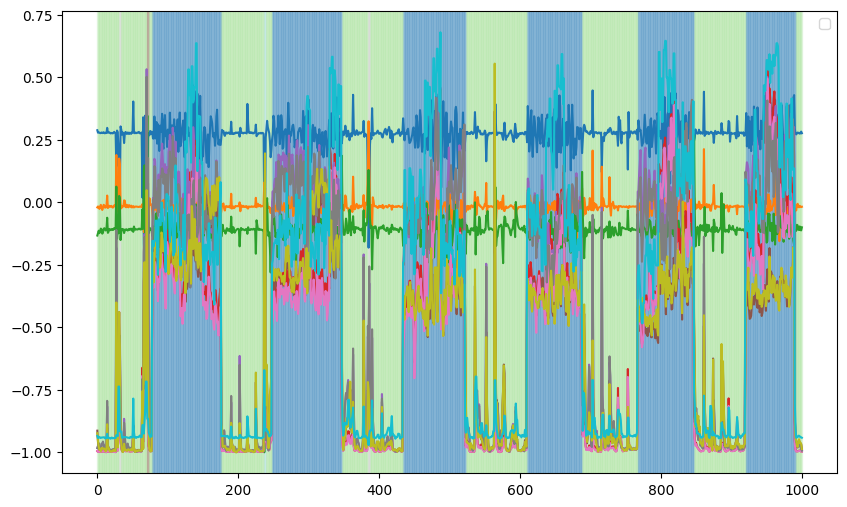

In [730]:
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
cmap = cm.Set1
# ラベルの一覧を取得します
num_clusters = len(set(labels))  # クラスタの数
cmap = cm.get_cmap('tab20', num_clusters) 
plt.figure(figsize=(10, 6))
plt.plot(data_test[:1000])  # cパラメータにクラスタラベルを渡す
#for i in range(len(date_list)-1):
for i in range(1000):
    plt.axvspan(date_list[i], date_list[i+1], color=cmap(labels[i]), alpha=0.2)
plt.legend() 
plt.show()

In [731]:
from sklearn.cluster import KMeans

# KMeansオブジェクトの作成。ここではクラスタ数（k）を6としています。
kmeans = KMeans(n_clusters=6)

# フィッティングとラベルの予測を行います
kmeans.fit(test_2d)
labels = kmeans.labels_
print(set(labels))

/Users/katoutsubasa/anaconda3/envs/tstest/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{0, 1, 2, 3, 4, 5}


/var/folders/m9/vc40_2nj7wgb3tgln7x3gdzc0000gn/T/ipykernel_7028/3849759323.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


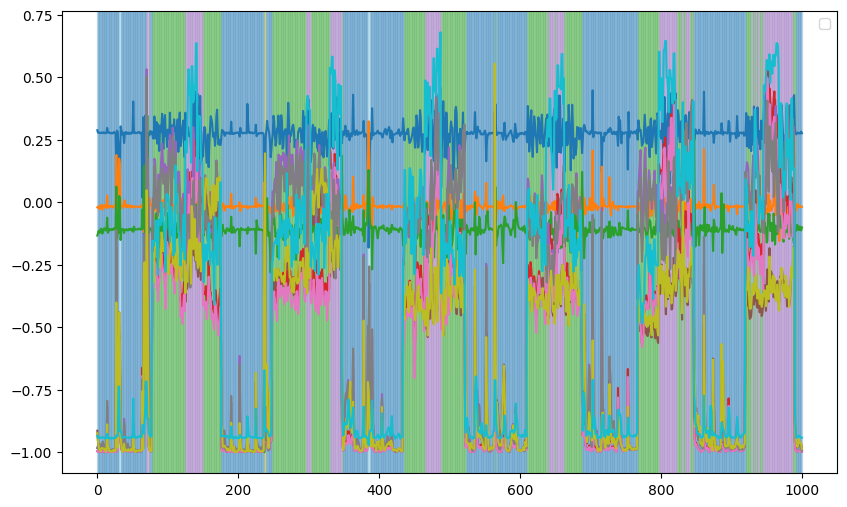

In [732]:
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
cmap = cm.Set1
# ラベルの一覧を取得します
num_clusters = len(set(labels))  # クラスタの数
cmap = cm.get_cmap('tab20', num_clusters) 
plt.figure(figsize=(10, 6))
plt.plot(data_test[:1000])  # cパラメータにクラスタラベルを渡す
#for i in range(len(date_list)-1):
for i in range(1000):
    plt.axvspan(date_list[i], date_list[i+1], color=cmap(labels[i]), alpha=0.2)
plt.legend() 
plt.show()

In [733]:
ari, anmi, nmi=evaluate_clustering(labels,y.numpy().tolist())
print('ARI: %f, ANMI: %f, NMI: %f' % ( ari, anmi, nmi))

ARI: 0.430857, ANMI: 0.604555, NMI: 0.608187


In [735]:
test1,test2,test3=evaluate_clustering([1,1,2,2,3,3],[2,2,3,3,1,1])
print('ARI: %f, ANMI: %f, NMI: %f' % ( test1,test2,test3))

ARI: 1.000000, ANMI: 1.000000, NMI: 1.000000


41


/var/folders/m9/vc40_2nj7wgb3tgln7x3gdzc0000gn/T/ipykernel_7028/203972373.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20', num_clusters)


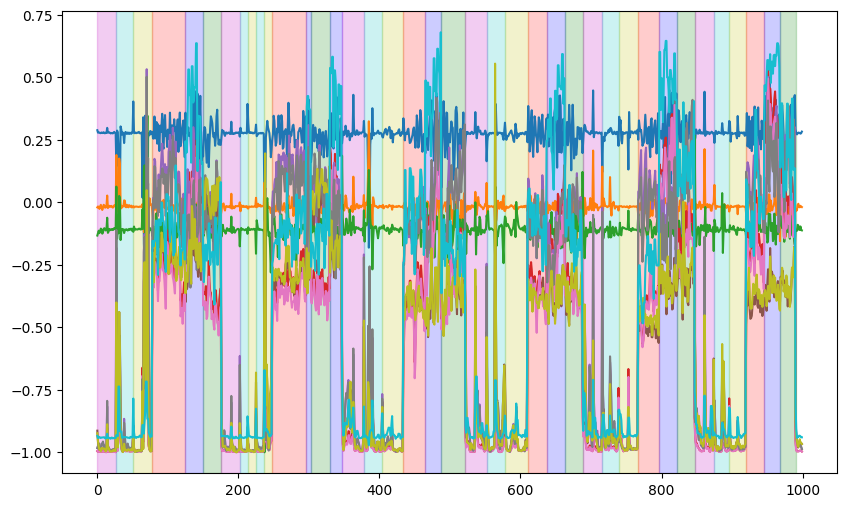

In [368]:
# 日付をエポック秒に変換
data_test_copy=data_test.copy()
# dateを1,2,3,...に変更
data_test_copy.reset_index(drop=True, inplace=True)
#data_test_copy['date'] = range(1, len(data_test_copy) + 1)
data_test_copy
plt.figure(figsize=(10, 6))

regime_list=[0,27, 51, 78, 125, 150, 176, 202, 213, 225, 237, 248, 296, 303, 330, 347, 378, 404, 434, 465, 488, 522, 552, 578, 610, 637, 663, 688, 716, 739, 767, 797, 822, 847, 875, 896, 920, 946, 968, 990]
num=[5.0, 4.0, 6.0, 1.0, 3.0, 2.0, 5.0, 4.0, 6.0, 4.0, 6.0, 1.0, 3.0, 2.0, 3.0, 5.0, 4.0, 6.0, 1.0, 3.0, 2.0, 5.0, 4.0, 6.0, 1.0, 3.0, 2.0, 5.0, 4.0, 6.0, 1.0, 3.0, 2.0, 5.0, 4.0, 6.0, 1.0, 3.0, 2.0, 5.0, 4.0, 6.0, 1.0, 3.0, 2.0, 5.0, 4.0, 6.0, 1.0, 3.0, 2.0, 5.0, 4.0, 6.0, 1.0, 3.0, 2.0, 5.0, 4.0, 6.0,]
#colors =  ["r", "g", "b", "c", "m", "g", "b", "c","m","y"]
colors=[]
print(len(regime_list)+1)
for i in range(len(regime_list)+1):
    if num[i]==1:
        colors.append("r")
    elif num[i]==2:
        colors.append("g")
    elif num[i]==3:
        colors.append("b")
    elif num[i]==4:
        colors.append("c")
    elif num[i]==5:
        colors.append("m")
    elif num[i]==6:
        colors.append("y")
    else:
        colors.append("k")
plt.plot(data_test_copy[:1000]) 
num_clusters = len(set(regime_list))  # クラスタの数
cmap = cm.get_cmap('tab20', num_clusters) 
for i in range(len(regime_list)-1):
    plt.axvspan(regime_list[i], regime_list[i+1], color=colors[i], alpha=0.2)

In [369]:
from sklearn.manifold import TSNE
regime_list=[0,27, 51, 78, 125, 150, 176, 202, 213, 225, 237, 248, 296, 303, 330, 347, 378, 404, 434, 465, 488, 522, 552, 578, 610, 637, 663, 688, 716, 739, 767, 797, 822, 847, 875, 896, 920, 946, 968, 990]
# t-SNEのモデルを作成
tsne = TSNE(n_components=3, random_state = 0, perplexity = 30, n_iter = 10000)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


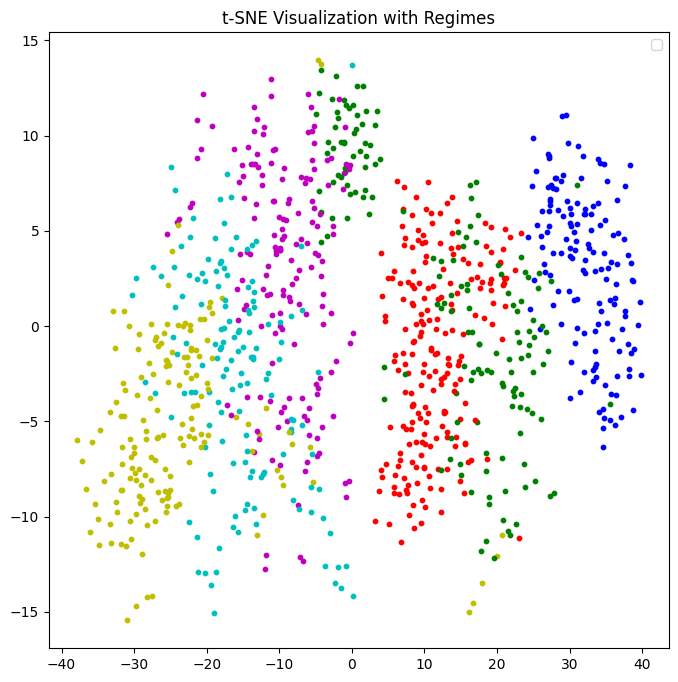

In [370]:
# 高次元データを低次元に変換
data_tsne = tsne.fit_transform(test_2d)
#regime_label=[0,1,2,3,4,1,2,3,4,5]

# 各regimeごとに色を指定
#colors =  ["r", "g", "b", "c", "m", "g", "b", "c","m","y"]

# プロット
plt.figure(figsize=(8, 8))

for i in range(len(regime_list) - 1):
    start_idx = regime_list[i]
    end_idx = regime_list[i + 1]
    plt.scatter(
        data_tsne[start_idx:end_idx, 0],
        data_tsne[start_idx:end_idx, 1],
        color=colors[i],
        #label=f"Regime {colors[i]}",
        s=10
    )
plt.title("t-SNE Visualization with Regimes")
plt.legend()
plt.show()

In [371]:
# from sklearn.manifold import TSNE
# regime_list=[0,19,200,338,550,665,840,970,1145,1300]
# t-SNEのモデルを作成
tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 15000)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


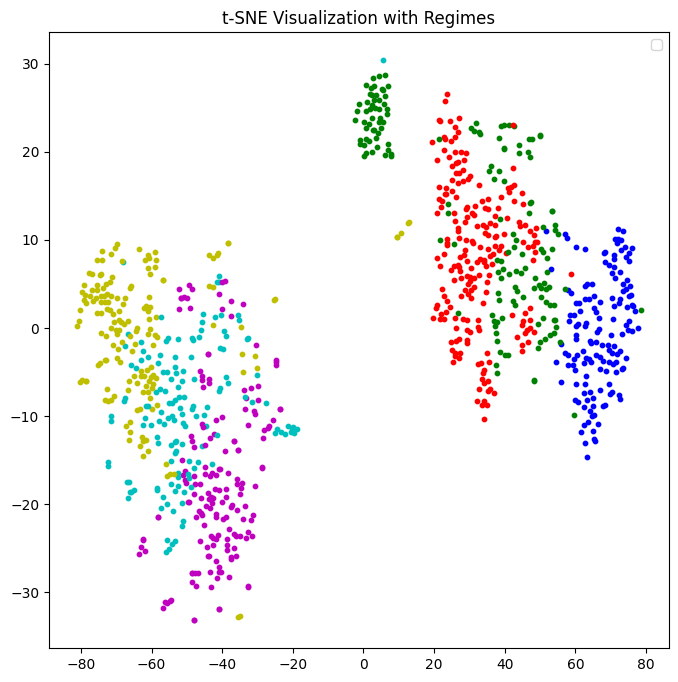

In [372]:
# 高次元データを低次元に変換
data_tsne = tsne.fit_transform(test_2d)
# regime_label=[0,1,2,3,4,1,2,3,4,5]

# # 各regimeごとに色を指定
# colors =  ["r", "g", "b", "c", "m", "g", "b", "c","m","y"]

# プロット
plt.figure(figsize=(8, 8))

for i in range(len(regime_list) - 1):
    start_idx = regime_list[i]
    end_idx = regime_list[i + 1]
    plt.scatter(
        data_tsne[start_idx:end_idx, 0],
        data_tsne[start_idx:end_idx, 1],
        color=colors[i],
        #label=f"Regime {colors[i]}",
        s=10
    )
plt.title("t-SNE Visualization with Regimes")
plt.legend()
plt.show()

In [901]:
from collections import Counter

def most_common_elements(lst):
    if not lst:
        return None  # リストが空の場合は None を返す
    counter = Counter(lst)
    max_count = counter.most_common(1)[0][1]  # 最も多い出現回数を取得
    most_common_elements = [elem for elem, count in counter.items() if count == max_count]
    return most_common_elements, max_count

# 使用例
example_list = [1, 3, 2, 1, 1, 3, 2, 2, 2, 4, 4, 4, 4]
elements, count = most_common_elements(example_list)
print(f"The most common elements are {elements} which each appear {count} times.")

The most common elements are [2, 4] which each appear 4 times.
